In [2]:
import os

from data_reader import Vocabulary, HWDBDatasetHelper, LMDBReader

root = "lmdb_data"
train_path = os.path.join(root, 'train.lmdb')
test_path = os.path.join(root, 'test.lmdb')
gt_path = './gt.txt'

In [3]:
import cv2
import numpy as np

### Data tools

In [4]:
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)

In [5]:
train_helper, val_helper = train_helper.train_val_split()

In [6]:
train_helper.size(), val_helper.size()

(2578433, 644609)

In [7]:
img, label = train_helper.get_item(42)

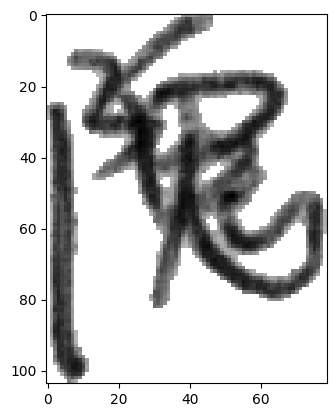

In [8]:
from matplotlib import pyplot as plt
plt.imshow(img, cmap='gray')

In [15]:
import torch

from torch.utils.data import Dataset, DataLoader
from torch import nn

class HWDBDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper):
        self.helper = helper
    
    def __len__(self):
        return self.helper.size()
    
    def __getitem__(self, idx):
        img, label = self.helper.get_item(idx)
        return (cv2.resize(img, (100, 100)) - 127.5) / 255., label

In [16]:
train_dataset = HWDBDataset(train_helper)
val_dataset = HWDBDataset(val_helper)

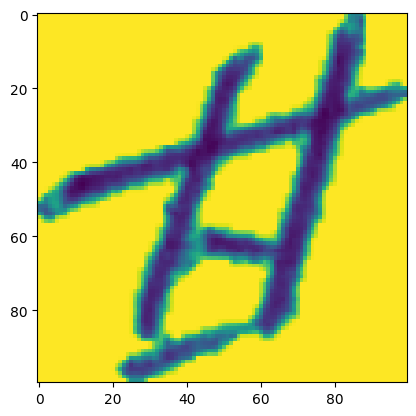

In [18]:
plt.imshow(train_dataset[6474][0])

### Model & training

In [20]:
from torchvision.models import resnet18, ResNet18_Weights


class Resnet18(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.emb_size = emb_size
        
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=self.resnet.conv1.out_channels,
            kernel_size=self.resnet.conv1.kernel_size,
            stride=self.resnet.conv1.stride,
            padding=self.resnet.conv1.padding,
            bias=self.resnet.conv1.bias,
        )
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, emb_size)
    
    def forward(self, x):
        return self.resnet(x)


In [21]:
model = Resnet18(emb_size=512)
model.eval()

Resnet18(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [22]:
model(torch.tensor(train_dataset[0][0], dtype=torch.float32).view(1, 1, 100, 100))

tensor([[-5.8869e-01, -3.5603e-01,  4.6400e-01, -3.1587e-01, -1.9961e-01,
          2.1459e-02,  6.5004e-02, -6.3255e-01,  1.5615e-01, -5.9866e-02,
          4.8402e-03,  4.8750e-01,  2.2677e-01, -8.4685e-01,  2.6867e-01,
         -6.8891e-02, -1.3789e-01,  4.9889e-01,  9.5932e-01,  5.1249e-01,
          1.2188e-01,  7.3940e-01, -6.4640e-01, -2.5306e-01, -7.7809e-01,
         -1.4451e-01, -2.2552e-01, -9.0050e-02, -1.0611e+00,  4.5012e-01,
          4.8947e-01, -3.7529e-01, -6.9373e-02, -7.9594e-02, -2.2767e-01,
         -4.4310e-01, -6.1136e-01,  9.4563e-02, -4.7999e-01,  2.0669e-01,
          3.3314e-01, -7.6535e-01,  1.5854e-01, -3.0396e-01, -8.5480e-01,
         -3.7421e-01,  7.0094e-01,  7.1420e-01,  1.7653e-01, -6.3356e-04,
         -9.7649e-03, -2.6495e-01, -4.4597e-01,  3.0424e-01, -3.4270e-01,
          6.4834e-01, -6.2257e-02,  1.4880e+00, -1.0157e-01,  5.4615e-01,
          1.8270e-02, -6.0402e-01, -1.3574e-01,  5.2194e-01,  1.3789e+00,
         -5.2111e-01, -2.2469e-01, -2.

In [23]:
model = model.cuda()

In [24]:
train_loader = DataLoader(train_dataset, batch_size=512, pin_memory=True, shuffle=True, drop_last=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=512, pin_memory=True, shuffle=False, num_workers=0)

In [25]:
from pytorch_metric_learning.losses import ArcFaceLoss
from itertools import chain

loss_fn = ArcFaceLoss(
    num_classes=train_helper.vocabulary.num_classes(),
    embedding_size=model.emb_size
).cuda()
# optim = torch.optim.AdamW(model.parameters())
optim = torch.optim.AdamW(chain(model.parameters(), loss_fn.parameters()))

In [26]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
    optim, 'min', patience = 10, factor=0.5, verbose=True
)

In [27]:
sum(p.numel() for p in model.parameters() if p.requires_grad), sum(p.numel() for p in loss_fn.parameters() if p.requires_grad)

(11432896, 3752960)

In [28]:
from tqdm import tqdm


def run_validation(val_loader: DataLoader, model: nn.Module, n_steps=None):
    model.eval()
    n_good = 0
    n_all = 0
    wrapper = lambda x: x
    if n_steps is None:
        n_steps = len(val_loader)
        wrapper = tqdm
    
    with torch.no_grad():
        for batch, (X, y) in enumerate(wrapper(val_loader)):
            if batch == n_steps:
                break
            logits = loss_fn.get_logits(model(X.unsqueeze(1).to(torch.float32).cuda()))
            classes = torch.argmax(logits, dim=1).cpu().numpy()
            n_good += sum(classes == y.cpu().numpy())
            n_all += len(classes)
    
    return n_good / n_all


def train_epoch(train_loader: DataLoader, val_loader: DataLoader, model: nn.Module, optim, loss_fn):
    for batch, (X, y) in enumerate(tqdm(train_loader)):
        model.train()
        logits = model(X.unsqueeze(1).to(torch.float32).cuda())
        loss = loss_fn(logits, y.to(torch.long).cuda())
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        if batch % 100 == 0:
            print(loss.item())
            # scheduler.step(loss)

In [29]:
torch.save(model.state_dict(), 'baseline.pth')

In [32]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [30]:
for epoch in range(2):
    print(f'Epoch {epoch}:')
    train_epoch(train_loader, val_loader, model, optim, loss_fn)
    accuracy = run_validation(val_loader, model)
    print(f'accuracy: {accuracy}')
    torch.save(model.state_dict(), f'baseline_epoch{epoch}.pth')

Epoch 0:


  0%|          | 2/5036 [00:03<2:06:11,  1.50s/it]

43.39341354370117


  2%|▏         | 102/5036 [00:20<15:20,  5.36it/s]

39.651649475097656


  4%|▍         | 202/5036 [00:38<15:01,  5.36it/s]

38.732521057128906


  6%|▌         | 302/5036 [00:55<14:36,  5.40it/s]

37.263607025146484


  8%|▊         | 402/5036 [01:12<14:25,  5.35it/s]

35.969635009765625


 10%|▉         | 502/5036 [01:29<14:03,  5.38it/s]

34.7155876159668


 12%|█▏        | 602/5036 [01:47<13:47,  5.36it/s]

32.799461364746094


 14%|█▍        | 702/5036 [02:04<13:29,  5.35it/s]

31.787582397460938


 16%|█▌        | 802/5036 [02:21<13:05,  5.39it/s]

29.608291625976562


 18%|█▊        | 902/5036 [02:39<12:49,  5.37it/s]

28.65727996826172


 20%|█▉        | 1002/5036 [02:56<12:39,  5.31it/s]

26.892414093017578


 22%|██▏       | 1102/5036 [03:13<12:11,  5.38it/s]

25.57768440246582


 24%|██▍       | 1202/5036 [03:31<11:51,  5.39it/s]

22.969499588012695


 26%|██▌       | 1302/5036 [03:48<11:48,  5.27it/s]

22.409727096557617


 28%|██▊       | 1402/5036 [04:05<11:17,  5.37it/s]

20.23763084411621


 30%|██▉       | 1502/5036 [04:23<10:55,  5.39it/s]

18.586307525634766


 32%|███▏      | 1602/5036 [04:40<10:46,  5.31it/s]

18.396392822265625


 34%|███▍      | 1702/5036 [04:57<10:22,  5.35it/s]

16.52039337158203


 36%|███▌      | 1802/5036 [05:15<10:01,  5.37it/s]

15.715768814086914


 38%|███▊      | 1902/5036 [05:32<09:45,  5.35it/s]

15.734771728515625


 40%|███▉      | 2002/5036 [05:49<09:36,  5.26it/s]

13.95914363861084


 42%|████▏     | 2102/5036 [06:07<09:09,  5.34it/s]

12.892192840576172


 44%|████▎     | 2202/5036 [06:24<08:46,  5.38it/s]

13.071582794189453


 46%|████▌     | 2302/5036 [06:41<08:37,  5.28it/s]

12.419955253601074


 48%|████▊     | 2402/5036 [06:59<08:09,  5.38it/s]

10.572257041931152


 50%|████▉     | 2502/5036 [07:16<08:00,  5.27it/s]

11.44497299194336


 52%|█████▏    | 2602/5036 [07:35<07:43,  5.25it/s]

11.102682113647461


 54%|█████▎    | 2702/5036 [07:52<07:17,  5.34it/s]

10.345990180969238


 56%|█████▌    | 2802/5036 [08:09<06:55,  5.37it/s]

10.070255279541016


 58%|█████▊    | 2902/5036 [08:27<06:39,  5.35it/s]

9.185242652893066


 60%|█████▉    | 3002/5036 [08:44<06:26,  5.27it/s]

9.016176223754883


 62%|██████▏   | 3102/5036 [09:01<06:02,  5.34it/s]

10.118941307067871


 64%|██████▎   | 3202/5036 [09:19<05:40,  5.38it/s]

8.359619140625


 66%|██████▌   | 3302/5036 [09:36<05:25,  5.33it/s]

8.588790893554688


 68%|██████▊   | 3402/5036 [09:54<05:04,  5.37it/s]

8.506790161132812


 70%|██████▉   | 3502/5036 [10:11<04:46,  5.36it/s]

7.103243350982666


 72%|███████▏  | 3602/5036 [10:28<04:31,  5.27it/s]

7.260709762573242


 74%|███████▎  | 3702/5036 [10:46<04:10,  5.33it/s]

6.8339009284973145


 75%|███████▌  | 3802/5036 [11:03<03:50,  5.35it/s]

7.607970237731934


 77%|███████▋  | 3902/5036 [11:20<03:33,  5.30it/s]

7.655501842498779


 79%|███████▉  | 4002/5036 [11:38<03:12,  5.38it/s]

6.692047119140625


 81%|████████▏ | 4102/5036 [11:55<02:54,  5.37it/s]

6.397280216217041


 83%|████████▎ | 4202/5036 [12:13<02:35,  5.38it/s]

7.218564987182617


 85%|████████▌ | 4302/5036 [12:30<02:18,  5.30it/s]

6.0182881355285645


 87%|████████▋ | 4402/5036 [12:47<01:58,  5.37it/s]

6.381040573120117


 89%|████████▉ | 4502/5036 [13:05<01:40,  5.33it/s]

5.868954181671143


 91%|█████████▏| 4602/5036 [13:22<01:21,  5.33it/s]

6.067690372467041


 93%|█████████▎| 4702/5036 [13:39<01:02,  5.37it/s]

6.275518417358398


 95%|█████████▌| 4802/5036 [13:57<00:43,  5.36it/s]

4.30633544921875


 97%|█████████▋| 4902/5036 [14:14<00:25,  5.35it/s]

5.309581279754639


 99%|█████████▉| 5002/5036 [14:32<00:06,  5.37it/s]

4.911807060241699


100%|██████████| 1260/1260 [02:52<00:00,  7.32it/s]


accuracy: 0.9403405785522697
Epoch 1:


  0%|          | 2/5036 [00:00<20:46,  4.04it/s]

5.045015335083008


  2%|▏         | 102/5036 [00:17<15:12,  5.40it/s]

4.3312482833862305


  4%|▍         | 202/5036 [00:35<15:00,  5.37it/s]

4.705455780029297


  6%|▌         | 302/5036 [00:52<14:38,  5.39it/s]

5.391546726226807


  8%|▊         | 402/5036 [01:09<14:22,  5.37it/s]

4.1530561447143555


 10%|▉         | 502/5036 [01:27<14:03,  5.37it/s]

3.7758724689483643


 12%|█▏        | 602/5036 [01:44<13:57,  5.30it/s]

4.819878578186035


 14%|█▍        | 702/5036 [02:01<13:25,  5.38it/s]

4.285112380981445


 16%|█▌        | 802/5036 [02:19<13:14,  5.33it/s]

5.240879058837891


 18%|█▊        | 902/5036 [02:36<12:47,  5.39it/s]

4.885817527770996


 20%|█▉        | 1002/5036 [02:53<12:30,  5.37it/s]

4.481380939483643


 22%|██▏       | 1102/5036 [03:11<12:18,  5.33it/s]

4.333968162536621


 24%|██▍       | 1202/5036 [03:28<11:52,  5.38it/s]

5.166199684143066


 26%|██▌       | 1302/5036 [03:46<11:34,  5.37it/s]

3.8154098987579346


 28%|██▊       | 1402/5036 [04:03<11:17,  5.36it/s]

4.209987640380859


 30%|██▉       | 1502/5036 [04:20<10:57,  5.38it/s]

5.395168304443359


 32%|███▏      | 1602/5036 [04:38<10:40,  5.36it/s]

3.9091615676879883


 34%|███▍      | 1702/5036 [04:55<10:22,  5.36it/s]

4.538150787353516


 36%|███▌      | 1802/5036 [05:12<09:59,  5.39it/s]

4.712396144866943


 38%|███▊      | 1902/5036 [05:30<09:44,  5.36it/s]

4.446807384490967


 40%|███▉      | 2002/5036 [05:47<09:25,  5.36it/s]

4.2893266677856445


 42%|████▏     | 2102/5036 [06:05<09:06,  5.37it/s]

4.001708507537842


 44%|████▎     | 2202/5036 [06:22<08:53,  5.31it/s]

4.713608264923096


 46%|████▌     | 2302/5036 [06:39<08:29,  5.37it/s]

4.264138221740723


 48%|████▊     | 2402/5036 [06:57<08:10,  5.37it/s]

3.505772113800049


 50%|████▉     | 2502/5036 [07:14<07:52,  5.36it/s]

4.372711658477783


 52%|█████▏    | 2602/5036 [07:31<07:44,  5.24it/s]

4.236436367034912


 54%|█████▎    | 2702/5036 [07:49<07:17,  5.34it/s]

4.338659286499023


 56%|█████▌    | 2802/5036 [08:06<06:56,  5.37it/s]

2.904418468475342


 58%|█████▊    | 2902/5036 [08:24<06:37,  5.36it/s]

4.60667610168457


 60%|█████▉    | 3002/5036 [08:41<06:26,  5.27it/s]

4.018531322479248


 62%|██████▏   | 3102/5036 [08:58<06:00,  5.36it/s]

5.176835060119629


 64%|██████▎   | 3202/5036 [09:16<05:41,  5.37it/s]

3.538804531097412


 66%|██████▌   | 3302/5036 [09:33<05:21,  5.39it/s]

3.5075204372406006


 68%|██████▊   | 3402/5036 [09:50<05:06,  5.33it/s]

4.2338409423828125


 70%|██████▉   | 3502/5036 [10:08<04:47,  5.34it/s]

3.7100954055786133


 72%|███████▏  | 3602/5036 [10:25<04:27,  5.36it/s]

3.4473330974578857


 74%|███████▎  | 3702/5036 [10:43<04:08,  5.36it/s]

4.332082748413086


 75%|███████▌  | 3802/5036 [11:00<03:49,  5.38it/s]

4.698712348937988


 77%|███████▋  | 3902/5036 [11:17<03:30,  5.38it/s]

3.605090618133545


 79%|███████▉  | 4002/5036 [11:35<03:13,  5.35it/s]

3.2100305557250977


 81%|████████▏ | 4102/5036 [11:52<02:54,  5.34it/s]

4.775030136108398


 83%|████████▎ | 4202/5036 [12:10<02:35,  5.36it/s]

3.9895029067993164


 85%|████████▌ | 4302/5036 [12:27<02:17,  5.33it/s]

3.9035258293151855


 87%|████████▋ | 4402/5036 [12:44<01:57,  5.40it/s]

3.356057643890381


 89%|████████▉ | 4502/5036 [13:02<01:39,  5.39it/s]

2.898590564727783


 91%|█████████▏| 4602/5036 [13:19<01:20,  5.37it/s]

5.27147102355957


 93%|█████████▎| 4702/5036 [13:36<01:02,  5.37it/s]

3.9055161476135254


 95%|█████████▌| 4802/5036 [13:54<00:43,  5.35it/s]

4.1492533683776855


 97%|█████████▋| 4902/5036 [14:11<00:25,  5.33it/s]

4.1871137619018555


 99%|█████████▉| 5002/5036 [14:29<00:06,  5.35it/s]

3.4854111671447754


100%|██████████| 1260/1260 [02:51<00:00,  7.35it/s]


accuracy: 0.9501325609788259
Epoch 2:


  0%|          | 2/5036 [00:00<21:03,  3.98it/s]

4.361516952514648


  0%|          | 8/5036 [00:01<18:13,  4.60it/s]


KeyboardInterrupt: 

### Evaluation

In [31]:
pred_path = './pred.txt'

test_reader = LMDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')

In [32]:
test_dataset = HWDBDataset(test_helper)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=0)

In [33]:
preds = []
model.eval()
with torch.no_grad():
    for X, _ in tqdm(test_loader):
        logits = loss_fn.get_logits(model(X.unsqueeze(1).to(torch.float32).cuda()))
        classes = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(classes)

  0%|          | 0/3034 [00:00<?, ?it/s]

100%|██████████| 3034/3034 [03:00<00:00, 16.83it/s]


In [34]:
with open(pred_path, 'w') as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        print(name, cls, file=f_pred)

In [35]:
from course_intro_ocr_t2.evaluate import evaluate

evaluate(gt_path, pred_path)

0.9319981507308863